# Tri par code NAF

On va essayer de regrouper les données par code NAF (*i.e.* par type d'entreprise), puis clusteriser séparèment et enfin d'afficher de manière sélective avec un `leaflet.ControlLayer`


In [1]:
import geopandas as gpd
from numpy.lib.financial import _pv_dispatcher
import pandas as pd
import numpy as np
import folium

from sklearn.cluster import KMeans

from shapely.geometry import Point, MultiPoint, Polygon

In [2]:
#Utilitaire

def swap_xy(geom):
    """
    Inverse les coordonnées de l'objet shapely.geometry.
    Utile pour passer objets shapely dans folium (la convention est inversée)
    :param geom: l'objet dont on veut inverser les coordonnées (Point, Polygon, MultiPolygon, etc.)
    :return: l'objet inversé
    """
    if geom.is_empty:
        return geom

    if geom.has_z:
        def swap_xy_coords(coords):
            for x, y, z in coords:
                yield (y, x, z)
    else:
        def swap_xy_coords(coords):
            for x, y in coords:
                yield (y, x)

    # Process coordinates from each supported geometry type
    if geom.type in ('Point', 'LineString', 'LinearRing'):
        return type(geom)(list(swap_xy_coords(geom.coords)))

    elif geom.type == 'Polygon':
        ring = geom.exterior
        shell = type(ring)(list(swap_xy_coords(ring.coords)))
        holes = list(geom.interiors)

        for pos, ring in enumerate(holes):
            holes[pos] = type(ring)(list(swap_xy_coords(ring.coords)))

        return type(geom)(shell, holes)

    elif geom.type.startswith('Multi') or geom.type == 'GeometryCollection':
        # Recursive call
        return type(geom)([swap_xy(part) for part in geom.geoms])

    else:
        raise ValueError('Type %r not recognized' % geom.type)


In [3]:
def nettoyer(df, reduce=False, threshold=1000):
    """
    Nettoie la DataFrame: enlève les na
    Si reduce=True, ne prend que les première données de la (Geo)DataFrame.
    La limite dans ce cas est fixée à threshold (qui vaut 1000 par défaut)
    """
    if reduce and df.size <= threshold:
        df = df[:threshold]

    return df.dropna(subset=["geometry"]).reset_index()

In [8]:
# On va maintenant commencer des tests : 

df = nettoyer(pd.read_json("../gis/input/base_sirene_shortened_json_cpp.json"))
len(df)

630080

In [5]:
df.head()

,index,apet700,libtefet,geometry
0,0,6820A,00-0salarié,"{'type': 'Point', 'coordinates': [2.348872, 48..."
1,1,4932Z,00-0salarié,"{'type': 'Point', 'coordinates': [2.396281, 48..."
2,2,8551Z,00-0salarié,"{'type': 'Point', 'coordinates': [2.297082, 48..."
3,3,4321A,NN-Unitésnonemployeuses,"{'type': 'Point', 'coordinates': [2.428486, 48..."
4,5,7022Z,00-0salarié,"{'type': 'Point', 'coordinates': [2.283437, 48..."


In [7]:
len(set(df['apet700']))
# On a 682 types d'entreprises différents

682

In [52]:
# on va analyser les types les + présents : 

compte_par_type = {}
for NAF in sorted(list(set(df['apet700']))):
    compte_par_type[NAF] = 0

# df.loc[0,:]['apet700']
for i in df['index']:
    if i == 630080:
        break
    ligne_consideree = df.loc[i,:]
    compte_par_type[ligne_consideree['apet700']] += 1


In [25]:
import matplotlib.pyplot as plt

In [30]:
# plt.scatter(compte_par_type.keys(), compte_par_type.values())
# plt.show()

In [40]:
les_5_max = sorted(list(compte_par_type.values()))[-5:]
# sorted(list(compte_par_type.values()))
les_5_max

[18565, 22757, 24650, 36099, 64432]

In [42]:
liste_plus_grands = []
for key, value in compte_par_type.items():
    if value in les_5_max:
        liste_plus_grands.append((key, value))

    if len(liste_plus_grands) == 5:
        break
liste_plus_grands

[('4932Z', 18565),
 ('6820A', 24650),
 ('6820B', 64432),
 ('7022Z', 36099),
 ('9499Z', 22757)]

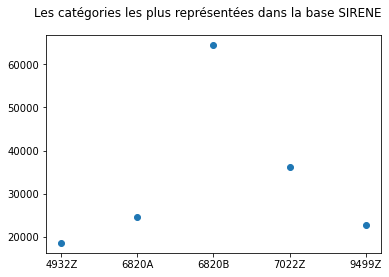

In [50]:
plt.scatter(
            [item[0] for item in liste_plus_grands],
            [item[1] for item in liste_plus_grands]
)
plt.suptitle("Les catégories les plus représentées dans la base SIRENE");

On va maintenant essayer de clusteriser les données de ces champs, les plus peuplés : 
```python
[('4932Z', 18565),
 ('6820A', 24650),
 ('6820B', 64432),
 ('7022Z', 36099),
 ('9499Z', 22757)]
 ```

In [58]:
# On va créer un table avec juste des apet700=='4932Z'

table_4932Z = df[df['apet700'] == '4932Z']
table_4932Z.shape


(19554, 4)

,index,apet700,libtefet,geometry
1,1,4932Z,00-0salarié,"{'type': 'Point', 'coordinates': [2.396281, 48..."
36,42,4932Z,00-0salarié,"{'type': 'Point', 'coordinates': [2.282955, 48..."
51,58,4932Z,00-0salarié,"{'type': 'Point', 'coordinates': [2.230273, 48..."
62,70,4932Z,NN-Unitésnonemployeuses,"{'type': 'Point', 'coordinates': [2.309378, 48..."
78,87,4932Z,00-0salarié,"{'type': 'Point', 'coordinates': [2.402212, 48..."
